# Chapter 7 - Simulation, Scenarios and Stress Testing
&copy; 2019 Kenneth Winston

In the previous chapter we saw a variety of distributions that can be used for situations that fall into Knight's [_a priori risk_](#frank_knight) category. If we are confident that a known distribution describes all the outcomes and all the associated probabilities for a set of variables, then we might even be able to get a closed-form description of relevant risk metrics for these variables.

But even if that situation obtains, our work isn't done. For financial applications, we'll probably want to know the rate of return of a portfolio. The portfolio could be a mutual fund, hedge fund, or institutional portfolio managed by an asset manager; it could be the positions on a trading desk; or it could be aggregate holdings of a sovereign wealth or endowment fund belonging to an asset owner.

The behavior of a portfolio of securities will be determined by a set of $k$ factors describing the financial and economic state of the world. These factors might come from a factor model like \eqref{eq:factor_practice}; they might be [key rates](#rolldown_key_rates); or they might just be individual securities. Whatever the inputs are, the sample space of interest will consist of $k$-vectors $fr$ ("factor realization") giving possible future states of the world. Often the convention is that such a state-of-the-world vector is expressed as a change from the current state.

Once we have the relevant state-of-the-world variables, we will also need deterministic pricing functions $R_i(fr)$ that give the rate of return of the $i^{th}$ security in a portfolio one period forward, conditional on state-of-the-world $fr$ being realized. Another function is then applied to the individual pricing functions to form a desired statistic at the portfolio level; for example $\text{Port}(R_1(fr),\dots,R_n(fr))=\ln\bigl(1+\sum w_i R_i(fr)\bigr)$ would give the portfolio's log-returns where $w$ is the portfolio weight vector.

For example, there are four parameters ($\beta_0$, $\beta_1$, $\beta_2$, and $\tau$) that describe a Nelson-Siegel curve in \eqref{eq:nelson_siegel}. If we are interested in modeling possible returns on a portfolio of bonds, then we might think that the relevant state-of-the-world sample space consists of 4-vectors giving the possible future values of the four Nelson-Siegel parameters. We might even think we have a state of Knightian Risk with respect to the Nelson-Siegel parameters: we have a good description of their probability distribution. But to value a portfolio of bonds being discounted by such a curve, we'll need to pass the four parameters through the formula \eqref{eq:nelson_siegel}, and then apply the pricing equation \eqref{eq:generic_pricing_equation} in order to get a pricing function $R_i(fr)$ for an individual bond. The portfolio return's response to changes in the four Nelson-Siegel parameters will therefore be highly nonlinear.

For cases where the responses to the state-of-the-world variables are complex, **`simulation`** is used. A process is developed to describe the sample space: this can be a closed-form approach, or a random-number generator producing a large number of samples of the state-of-the-world vector. Then, conditional on the future evolving according to the sample draw, the object of interest &mdash; such as a portfolio of bonds discounted by the Nelson-Siegel curve based on the sample parameters &mdash; is valued. The distribution of portfolio results is then analyzed for relevant statistics.

We have seen this technique already. The short rate models in sections 3.8.2 through 3.8.4 are examples of simulations; they generate a distribution of yield curves that can be used to value fixed income instruments. The resampled efficient frontier in section 4.2.2 is another example. An efficient portfolio is a highly nonlinear function of inputs such as a mean vector, a covariance matrix, and constraints. The resampling process is designed to produce an informative distribution of portfolios from which either a range or a center can be chosen.

We can consider these techniques _guided looks into the future_. If our technique is good, then the future that actually does unfold (and futures reasonably like the true one) will be among the outcomes, and their associated probabilities will cause us to plan appropriately.
<font color="white">$$\label{eq:factor_practice}\tag{5.40}$$
$$\label{eq:generic_pricing_equation}\tag{3.2}$$
$$\label{eq:nelson_siegel}\tag{3.14}$$
$$\label{eq:normal_var}\tag{2.8}$$
$$\label{eq:normal_cvar}\tag{2.9}$$
$$\label{eq:three_currency_sampcov}\tag{4.20}$$
</font> 

## 7.1 Historical Simulation

Perhaps the simplest way to generate outcomes and probabilities is **`historical simulation`**. In its purest form, this method requires no model other than the empirical history of the securities in our portfolio. The sample space is simply what happened in the past, and the associated probabilities can be totally agnostic &mdash; each historical observation has the same weight &mdash; or weighted according to a model such as: more recent observations are more important than older observations.

As we noted above, a more crafted version of historical simulation uses factor models for securities. Not only do factor models help give better predictions of future behavior; they also help with missing data. For example, we may own Facebook (FB) in our portfolio. Facebook common stock was not publicly traded before 2012. We may not consider that FB's history is not long enough to build up reliable estimates of its behavior. To address this problem, FB could be modeled as a linear combination of (1) an index of large American technology companies; and (2) an index of global social networking firms. Those indices go back in time further than FB itself, allowing the factors' empirical histories to fill in missing time periods.

We'll think about a historical simulation involving our Swissie, pound, yen example from section 4.1.2, using data going back to 1971. Our sample space will simply be all $T$ 3-vectors of (CHF,GBP,JPY) log-returns that we observed in the past, and our individual pricing functions will be $R_i(fr)=\exp(fr_i)-1$, where $fr$ is one of the 3-vectors in the sample space.

We'll suppose that the portfolio of interest is an equal-weighted portfolio of the three currencies, $w=(1/3, 1/3, 1/3)^{\prime}$. Let $X$ be the $T\times3$ matrix whose $(t,i)$ entry is the {(dollars per currency i on day t) divided by (dollars per currency i on day t-1)} minus one. $X$ is the priced sample space. The $T$-vector of log-returns at the portfolio level would be $\text{Port}(X)=\ln\bigl(1+Xw\bigr)$.

The $i^{th}$ observation of the $T$ observations in $\text{Port}(X)$ is assumed to have a probability $p_t$ of being observed. In this context we'll assume that time runs backward so $\text{Port}(X_1)$ is the most recent observation and $\text{Port}(X_T)$ is the oldest observation. In the agnostic version where we have no information to prioritize observations, $p_t=\frac{1}{T}\enspace\forall t$. 

We might think that going forward, the world will look more like it did last year than it did in 1971. In that case we would use an observation distribution $p_t$ where $p_i\geq p_j$ when $i\leq j$. A common technique is an **`exponentially weighted moving average`**, or **`EWMA`**: the observation probabilities are given by
$$p_t=\frac{2^{-h(t-1)}}{\sum_{s=0}^{T-1}2^{-hs}}=\frac{2^{-h(t-1)}(1-2^{-h})}{1-2^{-hT}}\approx2^{-h(t-1)}(1-2^{-h})\approx2^{-h(t-1)}\frac{h\cdot ln(2)}{1+\frac{h\cdot ln(2)}{2}}\label{eq:ewma}\tag{7.1}$$

$h=1/252$ in \eqref{eq:ewma} would be a one year half-life if the observation periodicity was business-daily, since there are about 252 business days in a year. In that case the observations from a year ago would be half as probable as the most recent observation; three years ago would be one eighth as probable.

A histogram of the outcomes (equally weighted in time) for the 3-currency portfolio (equally weighted by currency) is shown below. The pattern looks familiar:

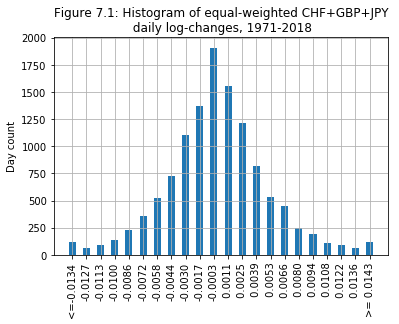

╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12036         │
├────────────────────┼───────────────┤
│ Min                │    -0.041114  │
├────────────────────┼───────────────┤
│ Max                │     0.0516067 │
├────────────────────┼───────────────┤
│ Mean               │     7.68e-05  │
├────────────────────┼───────────────┤
│ Median             │     1.21e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.0052379 │
├────────────────────┼───────────────┤
│ Skewness           │     0.24522   │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │     4.67289   │
├────────────────────┼───────────────┤
│ Jarque-Bera        │ 11071.3       │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0         │
├────────────────────┼───────────────┤
│ Serial Correlation │     0.0231905 │
├────────────────────┼───────────────┤
│ 99% VaR            │   

In [49]:
%matplotlib inline
import pandas as pd
import qrbook_funcs as qf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import stats
#Get 3 currencies until the end of
#previous year. Form sample covariance matrix
#and do simple efficient frontier calculations

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)

#Convert levels to log-returns
#First take logs of the currency levels
#Currency exchange rates are usually expressed in the direction
#that will make the rate > 1
#Swissie and yen are in currency/dollar, but
#pounds is in dollar/currency. Reverse signs
#so everything is in dollar/currency

#Do each currency separately to account for separate missing data patterns
#dlgs is a list of lists of length 3 corresponding to the 3 currencies
#The value in dlgs is nan if there is missing data for the present or previous day's observation
#Otherwise it is the log of today/yesterday
multipliers=[-1,1,-1]
dlgs=[]
for i in range(len(multipliers)):
    lgrates=[]
    previous=-1
    for t in range(len(ratematrix)):
        if pd.isna(ratematrix[t][i]) or ratematrix[t][i]<=0:
            lgrates.append(np.nan)    #Append a nan
        else:
            if previous < 0:    #This is the first data point
                lgrates.append(np.nan)
            else:
                lgrates.append(np.log(ratematrix[t][i]/previous)*multipliers[i])
            previous=ratematrix[t][i]
    dlgs.append(lgrates)

#dlgs is the transpose of what we want - flip it
dlgs=np.transpose(dlgs)

#Delete any time periods that don't have data
lgdates=[]
difflgs=[]
for t in range(len(dlgs)):
    if all(pd.notna(dlgs[t])):
        #include this time period
        difflgs.append(dlgs[t])
        lgdates.append(cdates[t])

#Mean vector and covariance matrix are inputs to efficient frontier calculations
d=np.array(difflgs)
m=np.mean(d,axis=0)
c=np.cov(d.T)

#Show histogram of equal-weighted
#CHF-GBP-JPY log-changes
w=np.array([1/3]*3).T
#apply transform to get returns at portfolio level
portfolio=np.log(1+np.dot(np.exp(difflgs)-1,w))
#portfolio now contains the equal-weighted portfolio's
#log-returns. Create buckets - hist function doesn't
#seem to have "x or less" or "x or more" buckets
bucketnames=[]
bucketcounts=[]
#Bucket the end percentiles
low1=np.percentile(portfolio,1)
high1=np.percentile(portfolio,99)
bucketnames.append('<=%7.4f' % low1)
bucketcounts.append(sum(1 for x in portfolio if low1 >= x))
#Count 20 even buckets in between low and high
nbucket=20
bucketwidth=(high1-low1)/nbucket
for i in range(20):
    attach=low1+i*bucketwidth
    detach=attach+bucketwidth
    mid=(attach+detach)/2
    bucketnames.append('%7.4f' % mid)
    bucketcounts.append(sum(1 for x in portfolio if (x>=attach and x<=detach)))

#last bucket
bucketnames.append('>=%7.4f' % high1)
bucketcounts.append(sum(1 for x in portfolio if x >= high1))

width=.5
plt.bar(range(nbucket+2),bucketcounts,width)
plt.xticks(range(nbucket+2),bucketnames,rotation='vertical')
plt.grid()
plt.ylabel('Day count')
plt.title('Figure 7.1: Histogram of equal-weighted CHF+GBP+JPY\n daily log-changes, '+lgdates[0][:4]+'-'+lastday[:4])
plt.show();
    
statnames,metrics,table=qf.StatsTable(np.exp(portfolio)-1)
headers=['Statistic','Value']
print(tabulate(table, headers, tablefmt='fancy_grid'))

The statistics table is based on daily portfolio returns. So our very simple look into the future of our equally weighted portfolio of Swissies, pounds and yen tells us that IF we expect the future to be like the 48 years 1971-2018, then
 - A typical daily rate of return will be about $\pm52bps$ (standard deviation = 52bps/day)
 - 99% of the time we will lose less than 1.332% a day (99% VaR)
 - When we do lose more than that, we’ll lose on average 1.723% (cVaR)
We will be drawing log-returns from the distribution shown in Figure 7.1 that looks normal at first glance, but is actually fat-tailed.

As it turns out we would have made a profit &mdash; more than doubling our money denominated in dollars over 48 years or about 1.94% a year (converted from log-returns). However for risk management purposes, quite often we ignore the mean or set it to zero. In many cases empirically (and as we see here), the mean is negligible compared to the volatility. That's usually true over short periods such as a day, but over longer periods such as a year, the mean may not be negligible. That's because the mean scales linearly with time, while standard deviation usually scales as the square root of time.

## 7.2 Delta-Normal

A second common method for generating future distributions is **`delta-normal`**. This method assumes that input variables &mdash; rates of return[$^1$](#seven_footnotes) of the three currencies in our example &mdash; will follow a multivariate normal distribution. Often the mean of the multivariate normal is assumed to be zero; as we noted above, for short periodicities the mean is usually negligible compared to the higher moments.

The delta-normal method starts by mapping portfolio holdings into the appropriate exposure vector $w$. As with our historical example, this vector may simply be a vector of weights of the securities in the portfolio, with an associated covariance matrix $C$.

For large institutional portfolios, the security-specific variance matrix $D$ in \eqref{eq:factor_practice} is often ignored. This is because in the quadratic form $w^{\prime}Dw$, only the squares of security weights appear. In a large portfolio, it is unlikely that any one security occupies more than a few percent, perhaps even less. Squaring a few percent gets down to basis points. Further, if the factor model is well-specified, the entries of $D$ are small. This is basically the argument that was made in the development of the [Arbitrage Pricing Theory](#arbitrage_pricing).

Thus we may take a vector of security weights $w$ and map it into factor loadings $b=B^{\prime}w$, where $B$ is the factor loading matrix in \eqref{eq:factor_practice}. In that case the associated covariance matrix is the $F$ in \eqref{eq:factor_practice}.

When there are more complex securities such as options, the **`delta`** (first-order sensitivity) of the security to an underlying linear security or factor is added in to the exposure vector. For fixed income instruments, duration would be used. This is what gives rise to the name "delta-normal."

In the delta-normal method, we can form the appropriate statistics directly. Let’s say $e$ is the exposure n-vector (either a security weight vector $w$ or a factor exposure vector $b$), and $M$ is the associated covariance matrix. Then the variance of the distribution of portfolio outcomes is $e^{\prime}Me$ and the standard deviation is $\sigma=\sqrt{e^{\prime}Me}$. The Value at Risk at probability $p$ is $v=-(\mu+\sigma*Norm^{-1}(1-p))$ as in \eqref{eq:normal_var}. At $p=99%$, that's $2.326\sigma$. The cVaR (= Expected Shortfall since Norm is continuous) (expressed as a loss amount) is
$$-\mu+\frac{\sigma}{(1-p)\sqrt{2\pi}}\exp\bigl(\frac{-v^2}{2\sigma^2}\bigr)$$
as in \eqref{eq:normal_cvar}.

The code in the next cell draws the histogram directly from the multivariate normal distribution, and generates the statistics table under the delta-normal assumption. We've used the mean from the historical data so as to make the statistics more directly comparable; in practice as noted we might just assume a zero mean.

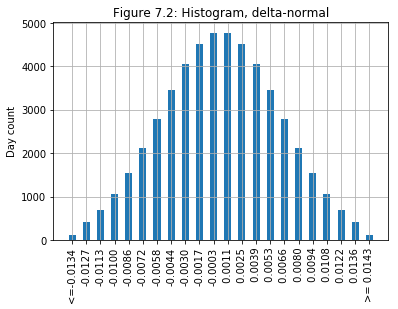

╒════════════════════╤════════════════╕
│ Statistic          │          Value │
╞════════════════════╪════════════════╡
│ Count              │ 12036          │
├────────────────────┼────────────────┤
│ Min                │    -0.019648   │
├────────────────────┼────────────────┤
│ Max                │     0.0198015  │
├────────────────────┼────────────────┤
│ Mean               │     7.68e-05   │
├────────────────────┼────────────────┤
│ Median             │     7.68e-05   │
├────────────────────┼────────────────┤
│ Standard Deviation │     0.00523816 │
├────────────────────┼────────────────┤
│ Skewness           │     0          │
├────────────────────┼────────────────┤
│ Excess Kurtosis    │     0          │
├────────────────────┼────────────────┤
│ Jarque-Bera        │     0          │
├────────────────────┼────────────────┤
│ Chi-Squared p      │     1          │
├────────────────────┼────────────────┤
│ Serial Correlation │     0          │
├────────────────────┼────────────────┤


In [51]:
# get count
count=metrics[0]
#Transform logs to return space
x_returns=np.array(np.exp(difflgs)-1)
m_returns=np.mean(x_returns,axis=0)
c_returns=np.cov(x_returns.T)
# compute mean and std deviation directly from m and c
port_mean=np.dot(m_returns,w)
port_std=np.sqrt(np.matmul(np.matmul(w,c_returns),w))

#Redo histogram with normal assumption

bucketcounts=[]
#Bucket the end percentiles
low1=port_mean+port_std*stats.norm.ppf(.01)
high1=port_mean+port_std*stats.norm.ppf(.99)
bucketwidth=(high1-low1)/nbucket
bucketcounts.append(stats.norm.cdf((low1-port_mean)/port_std)*count)
for i in range(nbucket):
    attach=low1+i*bucketwidth
    detach=attach+bucketwidth
    mid=(attach+detach)/2
    bucketnames.append('%7.4f' % mid)
    bucketcounts.append(stats.norm.pdf((mid-port_mean)/port_std)*count)

#last bucket
bucketcounts.append((1-stats.norm.cdf((high1-port_mean)/port_std))*count)

width=.5
plt.bar(range(nbucket+2),bucketcounts,width)
plt.xticks(range(nbucket+2),bucketnames,rotation='vertical')
plt.grid()
plt.ylabel('Day count')
plt.title('Figure 7.2: Histogram, delta-normal')
plt.show();

#Delta-normal calculations - redo the stats table
table_norm=np.copy(table)
#min
table_norm[1][1]=str(port_mean+stats.norm.ppf(1/(count+1))*port_std)
#max
table_norm[2][1]=str(port_mean+stats.norm.ppf(count/(count+1))*port_std)
#mean - should be the same
table_norm[3][1]='%7.7f' % port_mean
#median - make it equal the mean because normal
table_norm[4][1]=table_norm[3][1]
#standard deviation - use sqrt(w'Cw)
table_norm[5][1]=str(port_std)
#skewness - zero because normal
table_norm[6][1]="0"
#excess kurtosis - zero because normal
table_norm[7][1]="0"
#Jarque-Bera - zero because normal
table_norm[8][1]="0"
#Chi-squared - one because normal
table_norm[9][1]="1"
#Serial correlation - zero by assumption
table_norm[10][1]="0"
#99% VaR - from formula
p=.99
norm_VaR=-(port_mean+stats.norm.ppf(1-p)*port_std)
table_norm[11][1]=str(norm_VaR)
#99% cVar - from formula
norm_cVaR=port_std*np.exp(-.5*(norm_VaR/port_std)**2)
norm_cVaR/=(1-p)*np.sqrt(2*np.pi)
norm_cVaR=-port_mean+norm_cVaR
table_norm[12][1]=str(norm_cVaR)
print(tabulate(table_norm, headers, tablefmt='fancy_grid'))

Figure 7.2 looks generally similar to Figure 7.1, but 7.2 falls off at the tails while 7.1 has extra probability at the two extremes as a result of its leptokurtosis.

Note that the standard deviations of the historical simulation and the delta-normal method agree to four decimal places. Of course that's not a coincidence: if $X$ is the $T\times3$ matrix of daily returns of the three currencies, then the covariance matrix in \eqref{eq:three_currency_sampcov} was $C=(X-JX/T)^{\prime}(X-JX/T)/T$ where $J$ is the $T\times T$ matrix of all ones. The delta-normal calculation of standard deviation was $\sigma_{delta-normal}=\sqrt{w^{\prime}Cw}$.

The historical simulation's standard deviation was obtained by forming the $T$-vector $r=(X-JX/T)^{\prime}w$, and then taking its sample standard deviation $\sigma_{historical}=r^{\prime}r/T$. So $\sigma_{delta-normal}=\sigma_{historical}$ to within the precision of the calculation.

While the delta-normal method doesn’t deal with tail risk, it has a great advantage: we can apply the **`Euler rule`**. The Euler rule states that if $f(x)$ is a positive homogeneous and differentiable function of an $n$-vector $x=(x_1,\dots,x_n)$, then
$$z\cdot f(x)=\sum_{i=1}^n x_i \frac{\partial f}{\partial{x_i}}(x)\label{eq:euler_rule}\tag{7.2}$$

We've already discussed positive homogeneity in the context of [coherent risk measures](#coherent_risk) in Chapter 2; here positive homogeneity means that $f(kx)=k^z f(x)$ where $k$ is a positive scaler and $z$ is a scalar. We used $z=1$, but in fact \eqref{eq:euler_rule} works for any complex $z$.

We've know from our discussion of [coherent risk measures](#coherent_risk) that standard deviation ($\sqrt{w^{\prime} Cw}$) is positive homogenous with $z=1$. That allows us to decompose delta-normal standard deviation into the influences of each component:
$$\sigma(w)=\sqrt{w^{\prime}Cw}\text{; }\frac{\partial \sigma}{\partial w}=g=\frac{1}{\sigma}Cw\text{; }\sigma(w)=w^{\prime}g\label{eq:euler_std}\tag{7.3}$$
Here $g$ is the **`gradient vector`**. The right-hand side of \eqref{eq:euler_std} is a vector dot product – the vector version of the Euler decomposition in \eqref{eq:euler_rule}. The $i^{th}$ summand ($i=1$ to $n$) in the dot product is the contribution of the $i^{th}$ element to the overall delta-normal standard deviation.

Computing these quantities for the 3-currency example, we obtain the following:

In [52]:
#Compute gradient
port_gradient=np.matmul(c_returns,w)/port_std
print('Gradient (bps/day):',port_gradient)
print('Contributions to Std Dev:',port_gradient*w)

Gradient (bps/day): [0.00631147 0.00459635 0.00480666]
Contributions to Std Dev: [0.00210382 0.00153212 0.00160222]


From this we can see that the Swissie is the biggest contributer to standard deviation. If we think that one of the other currencies is going to outperform Swissies, we could shift some weight from the Swissie to that currency and have a win-win situation: increasing expected return while lowering expected risk. This works on the margin, but large changes in weights will require a reassessment of overall risk.

This helps to make risk/reward decisions. In more complex covariance matrices, we can even have some items with a negative contribution to overall standard deviation; those are diversifiers. If we think that a diversifier is going to generate more return than other items, then we can increase the exposure to the diversifier and get more return while reducing risk.

## 7.2.1 The Cornish-Fisher Expansion

One way of taking into account higher moments when computing Value at Risk is the **`Cornish-Fisher expansion`**. In the delta-Normal approach, VaR is simply $z\sigma$, where $\sigma$ is standard deviation and $z=Norm^{-1}(p)$; e.g. $z=2.326$ when $p=.99$. We saw, however that Historical Simulation VaR was higher than delta-Normal VaR, meaning the empirical $z$ multiple was bigger than the Gaussian $z$.

The Cornish-Fisher expansion (from a [1937 paper by E. A. Cornish & R. A. Fisher](https://doi.org/10.2307%2F1400905)) is essentially a Taylor series that takes into account moments of the distribution beyond the second moment to get a better estimate of the multiplier $z$. Taking into account the skewness and kurtosis terms gives
$$z_{new}=z-\frac{1}{6}(z^2-1)m_3+\frac{z}{24}(z^2-3)m_4-\frac{z}{36}(2z^2-6)m_3^2\label{eq:cornish_fisher}\tag{7.4}$$
Here $m_3$ is skewness and $m_4$ is (excess) kurtosis. For a normal distribution skewness and excess kurtosis are zero, so the Cornish-Fisher adjustment makes no change in that case.

[Maillard 2012](https://dx.doi.org/10.2139/ssrn.1997178) pointed out that the expansion only works in a certain range of skewness and kurtosis parameters. The absolute value of skewness must be outside a middle range, as shown:
$$6(\sqrt{2}-1)\geq|m_3|,\enspace6(\sqrt{2}+1)\leq|m_3|\label{eq:cornish_skewness}\tag{7.5}$$
So $|m_3|$ must be less that about $2.485$, or greater than about $14.485$. The top range &mdash; where skewness is greater than $14.485$ &mdash; is generally beyond repair by a simple adjustment. So the main applicability of Cornish-Fisher is in the lower range of skewness.

Kurtosis must be between the two roots of a quadratic:
$$4(1+11s^2-\sqrt{s^4-6s^2+1})\leq m_4\leq4(1+11s^2+\sqrt{s^4-6s^2+1})\label{eq:cornish_kurtosis}\tag{7.6}$$
where $s=m_3/6$. Thus when $s=0$, kurtosis must be between 0 and 8.

Figure 7.3 shows the valid parameter area for Cornish-Fisher in the lower range of skewness. Excess kurtosis is on the vertical axis; skewness is on the horizontal axis:

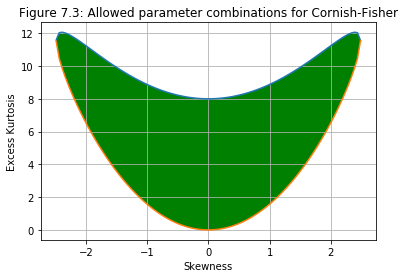

In [53]:
#Draw Cornish-Fisher admissability graph
stepsize=12*(np.sqrt(2)-1)/100
x=np.arange(-50*stepsize+.0001,
            50*stepsize,stepsize)
y1=[4*(1+11*(x/6)**2+np.sqrt((x/6)**4-6*(x/6)**2+1))][0]
y2=[4*(1+11*(x/6)**2-np.sqrt((x/6)**4-6*(x/6)**2+1))][0]
x=np.append(x,50*stepsize)
y1=np.append(y1,4*(1+11*(x[100]/6)**2))
y2=np.append(y2,4*(1+11*(x[100]/6)**2))
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2,facecolor='green')
plt.xlabel('Skewness')
plt.ylabel('Excess Kurtosis')
plt.title('Figure 7.3: Allowed parameter combinations for Cornish-Fisher')
plt.grid()
plt.show();

Applying \eqref{eq:cornish_fisher} to the Historical Simulation data above, we get the following:

In [54]:
#Compute new z-score using 7.4
z=stats.norm.ppf(p)
znew=z-(1/6)*(z**2-1)*stats.skew(portfolio)
znew+=(z/24)*(z**2-3)*stats.kurtosis(portfolio)
znew-=(z/36)*(2*z**2-5)*stats.skew(portfolio)**2
print_str='Normal %2.f pct' % np.multiply(p,100.)
print_str+=" z: %8.5f" % z
print(print_str)
print('Cornish-Fisher: %8.5f' % znew)
#Compare with historical
hs_99VaR=-np.percentile(portfolio,1)
zhist=(hs_99VaR+port_mean)/port_std
print('Historical: %8.5f' % zhist)

#Show comparisons of VaRs
print_str='\nNormal %2.f pct' % np.multiply(p,100.)
print_str+=" VaR: %8.5f" % norm_VaR
print(print_str)
cf_99VaR=-port_mean+znew*port_std
print('Cornish-Fisher VaR: %8.5f' % cf_99VaR)
print('Historical VaR: %8.5f' % hs_99VaR)

Normal 99 pct z:  2.32635
Cornish-Fisher:  3.23965
Historical:  2.57442

Normal 99 pct VaR:  0.01211
Cornish-Fisher VaR:  0.01689
Historical VaR:  0.01341


So in this case, the Cornish-Fisher expansion overcorrects, giving a more conservative Value at Risk than the one that arose from historical experience.

## 7.3 Monte Carlo Simulation

A third technique for generating distributions of portfolio outcomes is the **`Monte Carlo`** method. Monte Carlo is a reference to the casinos in Monaco, and indicates that a large number of random trials are generated to form a sample distribution. To illustrate this, we'll start with a delta-normal model but then will add complexity.

Suppose then that we have an $n\times n$ covariance matrix $M$ and an exposure $n$-vector $e$ for a portfolio. We want to draw an $n$-vector of factor (or security returns) from the multivariate normal distribution with covariance matrix $M$.
To do this, we must **`Cholesky factor`** $M$:
$$M=LL^{\prime}\text{  where }L\text{ is lower triangular}\label{eq:cholesky_factor}\tag{7.10}$$
If $M$ is positive semidefinite, then such a factorization is possible.

The algorithm for Cholesky factorization is straightforward. The lower triangular Cholesky factor of the 3-currency covariance matrix \eqref{three_currency_sampcov} is computed here:

In [68]:
#Show the Cholesky decomposition
#of the CHF-GPB-JPY covariance matrix
chol=np.linalg.cholesky(c)
print('(7.11) Cholesky decomposition of 3-currency sample covariance matrix:\n',chol*100)

(7.11) Cholesky decomposition of 3-currency sample covariance matrix:
 [[0.72070295 0.         0.        ]
 [0.34609443 0.48680727 0.        ]
 [0.30618222 0.0217864  0.56677204]]


<font color="white">$$\label{eq:cholesky_sampcov}\tag{7.11}$$</font>
We then generate n-vectors $s_j$ ($j=1$ to $T$, where $T$ the number of Monte Carlo trials desired) of independent draws from a standard (mean 0, standard deviation 1) normal distribution. So each $s_j$ consists of $n$ scalars each drawn independently from a standard normal distribution. The desired draw from the multivariate normal distribution is $r_j=Ls_j$. This is because
$$\mathbb{E}[r_jr_j^{\prime}]=\mathbb{E}[Ls_js_j^{\prime}L^{\prime}]=L\mathbb{E}[s_js_j^{\prime}]L^{\prime}=LL^{\prime}=M\label{eq:cholesky_expectation}\tag{7.12}$$

We run $T=12036$ trials, generating 3-vectors $s_1,\dots,s_T$. We form draws $r_i=Ls_i$. These return-vector draws are then dotted with the weight vector $w=(1/3, 1/3, 1/3)$ to generate $T$ rates of return.

In [76]:
#Generate random draws; use fixed seed to be replicable
seed=np.random.seed(12345678)
s_trial=np.random.normal(0,1,size=[int(count),3])
logr_trial=np.matmul(chol,s_trial.T).T+m

#logr_trial has Monte Carlo log-returns; transform to returns
r_trial=np.exp(logr_trial)-1

#Get trial portfolio returns
r_ptrial=np.matmul(r_trial,w)
statnames,mettrial,tabtrial=qf.StatsTable(r_ptrial)
print(tabulate(tabtrial, headers, tablefmt='fancy_grid'))

╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12036         │
├────────────────────┼───────────────┤
│ Min                │    -0.0203071 │
├────────────────────┼───────────────┤
│ Max                │     0.0214615 │
├────────────────────┼───────────────┤
│ Mean               │     6.65e-05  │
├────────────────────┼───────────────┤
│ Median             │     8.36e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.0052779 │
├────────────────────┼───────────────┤
│ Skewness           │     0.0010422 │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │     0.0373164 │
├────────────────────┼───────────────┤
│ Jarque-Bera        │     0.700526  │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0.704503  │
├────────────────────┼───────────────┤
│ Serial Correlation │     0.0013274 │
├────────────────────┼───────────────┤
│ 99% VaR            │   

These statistics are close to the statistics we got from the delta-normal method. There are some subtleties of the sampling distributions &mdash; even though we generated future outcomes by using draws from a normal distribution, there is some variation in what we will observe. For example, the skewness and kurtosis were not exactly zero in our sample, although they are zero in a true normal distribution. The standard deviation was slightly different.

The artificial future we generated using simple Monte Carlo looked a lot like the artificial future we generated using delta-normal, and the reasons for the differences are well understood: sampling error is limited and can be made smaller simply by running more trials.

### 7.3.1 Bartlett's Test

But what about variations we see in the real world? We've already discussed models and shrinkage techniques that are used to generate covariance matrices that are, we hope, better predictors of future covariance matrices than the past sample covariance matrix. 

For example, at this writing we don’t know what the covariance matrix will be between Swissies, pounds and yen for the 48 years 2019-2065. Even if we waited and observed that matrix T years from now, how would we tell if the T-years-forward covariance matrix was statistically the same as the T-years-back covariance matrix?

The short answer is we wouldn’t be able to tell, just as we wouldn’t be able to tell if we were handed two numbers. If I get 3 from one process and 3.1 from another process, are they close?


In [78]:
#Show sample covariance matrix (log-returns)
print('Monte Carlo covariance matrix:')
ctrial=np.cov(logr_trial.T)
print(ctrial*10000)
print('Historical covariance matrix')
print(c*10000)

Monte Carlo covariance matrix:
[[0.52144955 0.25494528 0.22517484]
 [0.25494528 0.36412202 0.12335106]
 [0.22517484 0.12335106 0.41459694]]
Historical covariance matrix
[[0.51941274 0.24943128 0.22066643]
 [0.24943128 0.35676267 0.11657374]
 [0.22066643 0.11657374 0.41545275]]


## Chapter 7 Footnotes
<a name="seven_footnotes"></a>
<br>
$^1$ It's more likely that log-returns follow a multivariate normal distribution than simple returns. Modeling log-returns as multivariate normal requires transformations back to return space; for simplicity we'll avoid those transformations at this point.